# Uplift моделирование - кому отправить смс, чтобы склонить к покупке

Необходимо для всех тестовых клиентов указать вероятность того, что клиент купит только при коммуникации (не купит без нее).

Модель будет оцениваться с помощью коэффициента Джини: gini = 2 * roc_auc - 1.

Это решение тестового задания для поступления на курсы от ЦФТ ШИФТ. Ссылка на соревнование Kaggle: https://www.kaggle.com/competitions/uplift-shift-23/

## Подготовка

### Импорт библиотек

In [1]:
from pathlib import Path
from typing import Dict

from numpy.typing import ArrayLike
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from catboost import CatBoostClassifier
from bayes_opt import BayesianOptimization

### Настройка ноутбука

In [2]:
pd.set_option('display.max_columns', 100)
sns.set()

In [3]:
# Оптимизация модели - долгий процесс, поэтому при 
# сохранении очередной версии ноутбука её можно отключить
need_optimization = False

# Зерно для случайных процессов
RANDOM = 999

### Загрузка данных

In [4]:
# Путь к файлам с данными
data_folder = Path('/', 'kaggle', 'input', 'uplift-shift-23', 'x5-uplift-valid')

In [5]:
# Общие данные
clients = pd.read_csv(data_folder / 'data' / 'clients2.csv', index_col='client_id', 
                      parse_dates=['first_issue_date', 'first_redeem_date'])
products = pd.read_csv(data_folder / 'data' / 'products.csv', index_col='product_id')

In [6]:
# Тренировочные данные
train = pd.read_csv(data_folder / 'data' / 'train.csv', index_col='client_id')
train_purch = pd.read_csv(data_folder / 'train_purch' / 'train_purch.csv', 
                          parse_dates=['transaction_datetime'])

In [7]:
# Тестовые данные
test = pd.read_csv(data_folder / 'data' / 'test.csv', index_col='client_id')
test_purch = pd.read_csv(data_folder / 'test_purch' / 'test_purch.csv', 
                         parse_dates=['transaction_datetime'])

### Приведение к удобному виду

In [8]:
# Объединим train_purch и test_purch
# Вычисления могут быть дольше, но код писать будет удобнее
purchases = pd.concat([train_purch, test_purch], axis=0)

## Анализ данных

### train и test - данные для обучения и предсказания

+ количество клиентов, с кем была коммуникация, и тех, с кем не было коммуникации равны;
+ количество купивших клиентов больше (60 к 40);
+ в выборке для предсказанию представлены только id клиентов.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140027 entries, ad6561e2d8 to 1430184499
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   treatment_flg  140027 non-null  int64
 1   purchased      140027 non-null  int64
dtypes: int64(2)
memory usage: 3.2+ MB


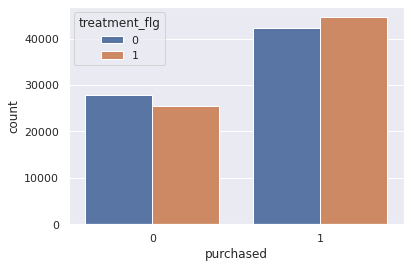

In [10]:
sns.countplot(data=train, x='purchased', hue='treatment_flg');

In [11]:
print(f'test.shape = {test.shape}')
test.head()

test.shape = (60012, 0)


""
client_id
a9a604ed6e
ebd7360016
908cd9b8e8
dceb8ce861
f4f0ac6b06


### clients - данные о клиентах

+ в переменной `first_redeem_date` есть пропущенные значения;
+ признак `age` содержит выбросы;

In [12]:
clients.head()

,client_id.1,first_issue_date,first_redeem_date,age,gender
client_id,,,,,
000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [13]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200039 entries, 000012768d to fffff6ce77
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id.1        0 non-null       float64       
 1   first_issue_date   200039 non-null  datetime64[ns]
 2   first_redeem_date  182493 non-null  datetime64[ns]
 3   age                200039 non-null  int64         
 4   gender             200039 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 9.2+ MB


In [14]:
clients.describe(datetime_is_numeric=True)

,client_id.1,first_issue_date,first_redeem_date,age
count,0.0,200039,182493,200039.000000
mean,NaN,2018-01-09 09:55:14.894200576,2018-06-26 08:59:51.341536256,46.417329
min,NaN,2017-04-04 18:24:18,2017-04-11 09:42:20,-7491.000000
25%,NaN,2017-07-21 16:52:46,2017-12-24 10:52:30,34.000000
50%,NaN,2017-11-15 20:45:16,2018-06-06 17:15:02,45.000000
75%,NaN,2018-06-20 17:47:54.500000,2019-01-04 20:22:05,59.000000
max,NaN,2019-03-15 21:44:14,2019-11-20 01:14:10,1852.000000
std,NaN,NaN,NaN,49.532475


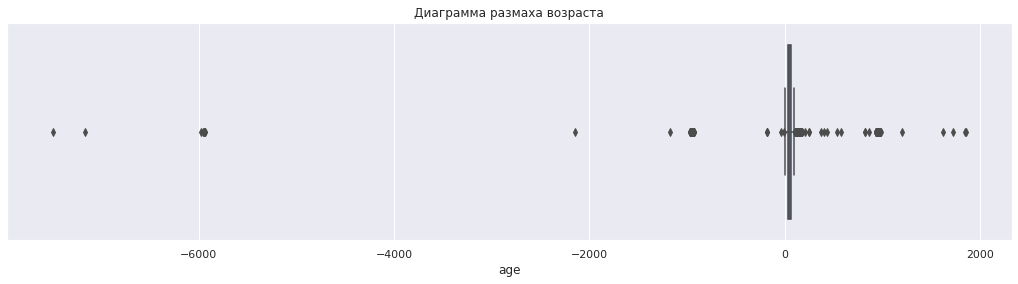

In [15]:
plt.figure(figsize=(18, 4))
sns.boxplot(x=clients['age'])
plt.title('Диаграмма размаха возраста');

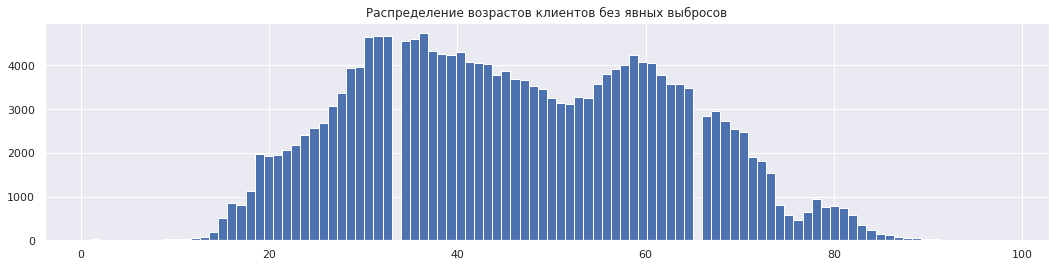

In [16]:
plt.figure(figsize=(18, 4))
plt.title('Распределение возрастов клиентов без явных выбросов')
clients[(clients['age'] > 0) & (clients['age'] < 100)]['age'].hist(bins=100);

In [17]:
clients['gender'].value_counts(dropna=False, normalize=True)

U    0.464070
F    0.368408
M    0.167522
Name: gender, dtype: float64

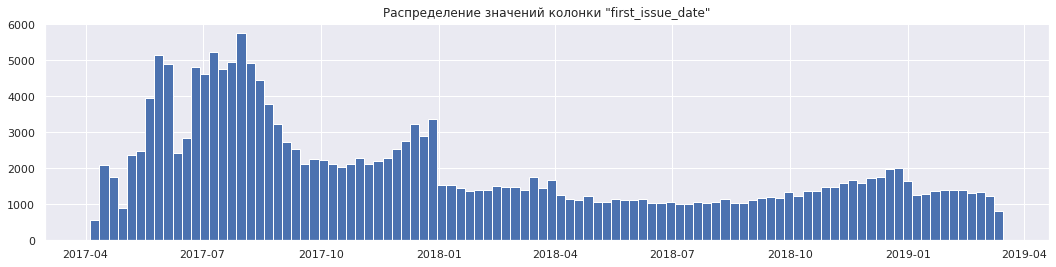

In [18]:
plt.figure(figsize=(18, 4))
plt.title('Распределение значений колонки "first_issue_date"')
clients['first_issue_date'].hist(bins=100);

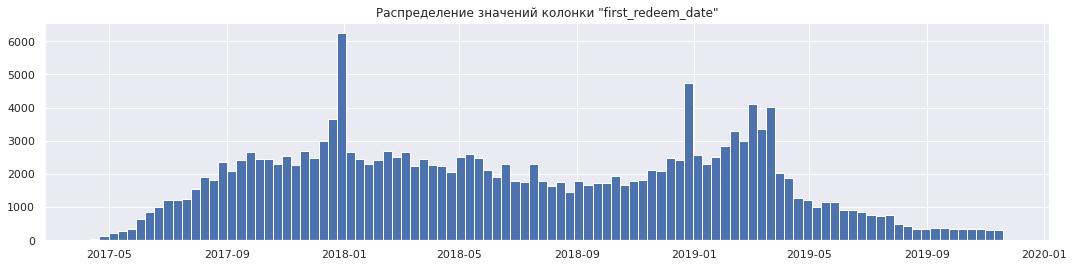

In [19]:
plt.figure(figsize=(18, 4))
plt.title('Распределение значений колонки "first_redeem_date"')
clients['first_redeem_date'].hist(bins=100);

### products - данные о продукции

+ во многих признаках есть пропуски;
+ в переменных `level_1`, `is_own_trademark`, `is_alcohol` уникальных значений немного, их будет удобно использовать для генерации признаков;

In [20]:
products.head()

,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
product_id,,,,,,,,,,
0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [21]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43038 entries, 0003020d3c to fffd992186
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   level_1           43035 non-null  object 
 1   level_2           43035 non-null  object 
 2   level_3           43035 non-null  object 
 3   level_4           43035 non-null  object 
 4   segment_id        41466 non-null  float64
 5   brand_id          37838 non-null  object 
 6   vendor_id         43004 non-null  object 
 7   netto             43035 non-null  float64
 8   is_own_trademark  43038 non-null  int64  
 9   is_alcohol        43038 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 3.6+ MB


In [22]:
products.describe(include='all')

,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
count,43035,43035,43035,43035,41466.000000,37838,43004,43035.000000,43038.000000,43038.000000
unique,3,42,201,790,NaN,4296,3193,NaN,NaN,NaN
top,e344ab2e71,52f13dac0c,ca69ed9de2,420c3b3f0b,NaN,0d6f137fb6,43acd80c1a,NaN,NaN,NaN
freq,22183,8891,3737,2500,NaN,4344,1514,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,153.918222,NaN,NaN,0.536966,0.035178,0.055602
std,NaN,NaN,NaN,NaN,82.271376,NaN,NaN,8.274367,0.184232,0.229154
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,105.000000,NaN,NaN,0.150000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,148.000000,NaN,NaN,0.300000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,214.000000,NaN,NaN,0.500000,0.000000,0.000000


### purchases - данные о покупках

In [23]:
purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [24]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22882690 entries, 0 to 6883737
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   client_id                object        
 1   transaction_id           object        
 2   transaction_datetime     datetime64[ns]
 3   regular_points_received  float64       
 4   express_points_received  float64       
 5   regular_points_spent     float64       
 6   express_points_spent     float64       
 7   purchase_sum             float64       
 8   store_id                 object        
 9   product_id               object        
 10  product_quantity         float64       
 11  trn_sum_from_iss         float64       
 12  trn_sum_from_red         float64       
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 2.4+ GB


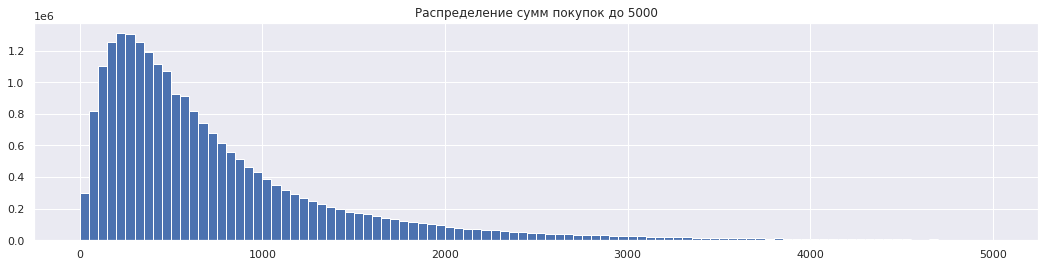

In [25]:
plt.figure(figsize=(18, 4))
plt.title('Распределение сумм покупок до 5000')
purchases[purchases['purchase_sum'] < 5000]['purchase_sum'].hist(bins=100);

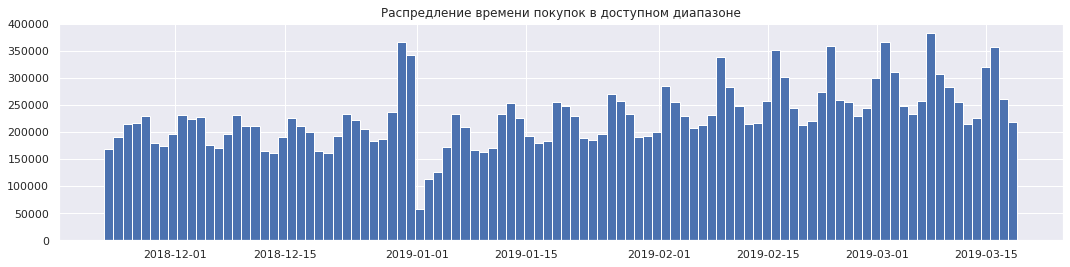

In [26]:
plt.figure(figsize=(18, 4))
plt.title('Распредление времени покупок в доступном диапазоне')
purchases['transaction_datetime'].hist(bins=100);

## Часть 1. Ответы на вопросы

Ответы на вопросы из формы: https://docs.google.com/forms/d/e/1FAIpQLSf_jHf8BKSgX9AykmgeI2YnKR_rPcFFY6dyj-DRzqyuW4Ckmw/viewform

In [27]:
def calculate_uplift(data: pd.DataFrame) -> float:
    """Рассчитывает значение аплифта."""
    with_treatment = data[data['treatment_flg'] == 1]['purchased'].mean()
    without_treatment = data[data['treatment_flg'] == 0]['purchased'].mean()
    return with_treatment - without_treatment

In [28]:
# Выделим данные о клиентах в тренировочной выборке
train_clients = train.join(clients)

### Вопрос 1
Каково значение аплифта на всем трейне?  
13.43%, 1.28%, 3.34% или 8.67%

**Ответ**: 3.34%

In [29]:
uplift = calculate_uplift(train)
print(f'Uplift на всем тренировочном датасете: {uplift:0.2%}')

Uplift на всем тренировочном датасете: 3.35%


### Вопрос 2
Выберите правильные утверждения:  
1. Аплифт в группе людей, возраст которых больше 50 лет, примерно в два раза выше чем у остальных людей.  
2. В трейне мужчин больше чем женщин.  
3. Медианный возраст всех людей в трейне равен 39 годам.  
4. Последняя покупка в train_purch была совершена в марте 2018 года.  

**Ответ**: Верно только утверждение 1.

In [30]:
# Uplift людей старше 50

uplift_age_more_50 = calculate_uplift(train[train_clients['age'] > 50])
uplift_age_less_50 = calculate_uplift(train[train_clients['age'] <= 50])

uplift_ratio_age_50 = uplift_age_more_50 / uplift_age_less_50
print(f'Uplift в группе людей старше 50 в {uplift_ratio_age_50:0.2f} раза выше чем у остальных.')

Uplift в группе людей старше 50 в 2.38 раза выше чем у остальных.


In [31]:
# Сравнение количества мужчин и женщин

male_count, female_count = train_clients['gender'].value_counts()[['M', 'F']]
print(f'Мужчин ({male_count}) в тренировочном датасете больше '
      f'чем женщин ({female_count}): {male_count > female_count}')

Мужчин (23503) в тренировочном датасете больше чем женщин (51559): False


In [32]:
# Медианный возраст в трейне

print(f'Медианный возраст в тренировочном датасете: {train_clients["age"].median()}')

Медианный возраст в тренировочном датасете: 45.0


In [33]:
# Последняя покупка в трейне

latest_purch = train_purch['transaction_datetime'].max()
print(f'Последняя покупка в тренировочном сете произведена: {latest_purch}')

Последняя покупка в тренировочном сете произведена: 2019-03-18 23:19:28


### Вопрос 3

На какую максимальную сумму в train_purch была совершена покупка?  
21169, 29611, 21187 или 27811?

**Ответ**: 29611

In [34]:
max_train_purchase_sum = train_purch['purchase_sum'].max()
print(f'В тренировочном датасете максимальная стоимость '
      f'покупки составила: {max_train_purchase_sum:0.0f}')

В тренировочном датасете максимальная стоимость покупки составила: 29611


### Вопрос 4

Каково мат. ожидание кол-ва посетителей во всех магазин в train_purch в день?  
24658, 26548, 23856 или 28365?

**Ответ**: 23856

In [35]:
train_purch_id_date = pd.concat(
    [train_purch['transaction_id'], train_purch['transaction_datetime'].dt.date], axis=1)
mean_clients_for_day = \
    train_purch_id_date.groupby('transaction_datetime')['transaction_id'].nunique().mean()
print(f'Для тренировочной выборки в день во всех магазинах '
      f'ожидается {mean_clients_for_day:0.0f} покупателей.')

Для тренировочной выборки в день во всех магазинах ожидается 23856 покупателей.


### Вопрос 5

Какого значения аплифта можно достичь, если осуществить воздействие на людей, с момента последней покупки которых прошло 10 и более дней?  
3.72%, 3.27%, 4.23% или 4.32%?

**Ответ**: 3.72%

In [36]:
# Определим с какого времени считать, что прошло 10 дней
boundary_10_days = train_purch['transaction_datetime'].max() - pd.Timedelta(10, 'd')

# Определим когда была совершена последняя покупка для клиентов
last_transaction_datetime = train_purch.groupby('client_id')['transaction_datetime'].max()[train_clients.index]

# Посчитаем аплифт
uplift_10_days = calculate_uplift(train_clients[last_transaction_datetime <= boundary_10_days])
print(f'Uplift для людей, с момента последней покупки которых прошло 10 и более дней - {uplift_10_days:0.2%}')

Uplift для людей, с момента последней покупки которых прошло 10 и более дней - 3.72%


### Вопрос 6

Какова доля продукции собственного производства в покупках среди всех покупок?  
16.1%, 15.2%, 12.5% или 11.6%?

**Ответ**: 15.2%

Это наиболее близкий ответ к моему. 

In [37]:
# По количеству проданных товаров

product_counts = purchases.groupby('product_id')['product_quantity'].sum()
product_counts_own = product_counts[products['is_own_trademark'] == 1].sum()

print(f'Доля продукции собственного производства по количеству проданных'
      f' товаров - {product_counts_own / product_counts.sum():0.2%}')

Доля продукции собственного производства по количеству проданных товаров - 15.08%


In [38]:
# По суммарной стоимости проданных товаров

product_sums = purchases.groupby('product_id')['trn_sum_from_iss'].sum()
product_sums_own = product_sums[products['is_own_trademark'] == 1].sum()

print(f'Доля продукции собственного производства по стоимости проданных'
      f' товаров - {product_sums_own / product_sums.sum():0.2%}')

Доля продукции собственного производства по стоимости проданных товаров - 9.75%


### Вопрос 7

Влияет ли факт покупки самого популярного продукта на аплифт? Если влияет, то каково значение аплифта?  
0.03%, 6.42%, 1.19% или 2.64%?

**Ответ**: 2.64%

In [39]:
# Самый популярный продукт - тот, который покупали чаще всего
most_popular_product = train_purch.groupby('product_id')['product_quantity'].sum().idxmax()

# Клиенты, купившие самый популярный продукт
client_with_popular_product = train_purch[train_purch['product_id'] == most_popular_product]['client_id'].unique()

# Uplift
uplift_popular_product = calculate_uplift(train[train.index.isin(client_with_popular_product)])
print(f'Uplift для клиентов, купивших самый популярный продукт составил {uplift_popular_product:0.2%}')

Uplift для клиентов, купивших самый популярный продукт составил 2.64%


### Вопрос 8

Разделим покупателей на две группы: владеют картой покупателя > 100 дней (группа А), владеют картой покупателя <= 100 дней (группа Б). Правда ли то, что аплифт в группе А меньше, чем в группе Б? Если правда, то на сколько меньше (разница между процентами)?  
Правда. 3.10%; Правда. 2.36%; Не правда. -3.10%; Не правда. -2.36%?

**Ответ**: Правда 2.36%

Это наиболее близкий ответ к моему.

In [40]:
# Определим с какого момента считать 100 дней владения картой
boundary_100_days = test_purch['transaction_datetime'].max() - pd.Timedelta(100, 'days')

# `first_issue_date` - это дата первого выпуска карты
more_than_100_days = train_clients['first_issue_date'].dt.round('d') < boundary_100_days

# Посчитаем uplift
uplift_group_a = calculate_uplift(train_clients[more_than_100_days])
uplift_group_b = calculate_uplift(train_clients[~more_than_100_days])
print(f'Uplift для покупателей, владеющих картой <= 100 дней, выше на '
      f'{uplift_group_b - uplift_group_a:0.2%}, чем для остальных покупателей.')

Uplift для покупателей, владеющих картой <= 100 дней, выше на 2.39%, чем для остальных покупателей.


### Вопрос 9 

Разделим покупателей на две группы: покупали продукты собственного производства хоть раз (группа А), вообще не покупали продукты собственного производства (группа Б). Правда ли то, что аплифт в группе А меньше чем в группе Б? Если правда, то на сколько меньше?  
Правда, почти 4%; Не правда, почти -5%; Правда, почти 5% или Не правда, почти -4%?

**Ответ**: Правда, почти 5%

In [41]:
# Определим продукты собственного производства и клиентов, их покупавших
products_with_own_trademark = products[products['is_own_trademark'] == 1].index
purch_with_own_trademark = train_purch[train_purch['product_id'].isin(products_with_own_trademark)]
clients_who_bought = train_clients.index.isin(purch_with_own_trademark['client_id'].unique())

# Посчитаем uplift
uplift_group_a = calculate_uplift(train_clients[clients_who_bought])
uplift_group_b = calculate_uplift(train_clients[~clients_who_bought])
print(f'Uplift в группе людей, не покупавших продукты собственного '
      f'производства, выше на {(uplift_group_b - uplift_group_a):0.2%}.')

Uplift в группе людей, не покупавших продукты собственного производства, выше на 4.73%.


### Вопрос 10

Разделим покупателей на две группы. В группе А у большей части покупок клиента чек больше среднего чека по всей выборке. В группе Б у  большей части покупок клиента чек меньше среднего чека по всей выборке. Правда ли то, что аплифт в группе А меньше, чем в группе Б?  
Не правда, -5.6%; Не правда, -0.56%; Правда, 5.6%; Правда, 0.56%?

**Ответ**: Правда, 0.56%

In [42]:
# Отдельные покупки клиентов тренировочной выборки
train_clients_transactions = \
    train_purch.groupby(['client_id', 'transaction_id'])['purchase_sum'].first().reset_index()

# Средний чек по тренировочной выборке
train_mean_check = train_clients_transactions['purchase_sum'].mean()

# Определим, больше ли среднего чека отдельная покупка 
train_clients_transactions['more'] = train_clients_transactions['purchase_sum'] > train_mean_check

# Доля покупок клиентов, которые больше среднего чека
fraction_more_mean_check = train_clients_transactions.groupby('client_id')['more'].mean()

# Выделим клиентов, у кого большая часть покупок больше среднего чека
train_clients_group_a = (fraction_more_mean_check > 0.5)[train.index]

# Uplift
uplift_group_a = calculate_uplift(train[train_clients_group_a])
uplift_group_b = calculate_uplift(train[~train_clients_group_a])
print(f'Uplift в группе Б выше на {uplift_group_b - uplift_group_a:0.2%} чем в группе А.')

Uplift в группе Б выше на 0.56% чем в группе А.


### Очистка памяти

In [43]:
del train_clients, train_purch, test_purch

## Часть 2. Предсказание убеждаемых клиентов

### Подготовка данных

#### Получение целевой переменной

Удобный способ получить таргет в задачах uplift-прогнозирования - это отметить 1 клиентов из тестовой группы, совершивших покупку, и клиентов из контрольной группы, покупку не совершивших.

Целевая переменная распределена почти равномерно.

In [44]:
train_target = (train['treatment_flg'] == train['purchased']).astype(int)
train_target.value_counts(dropna=False, normalize=True)

1    0.51685
0    0.48315
dtype: float64

#### Генерация признаков


In [45]:
# Дата последней покупки + 1 день, условно можно считать датой совершения коммуникации
last_day_plus_one = (purchases['transaction_datetime'].max() + pd.Timedelta(1, 'd')).round('d')

# Признаки, повторяющиеся для каждой транзакции в purchases
one_transaction_columns = [
    'client_id','transaction_datetime', 'regular_points_received', 'express_points_received', 
    'regular_points_spent', 'express_points_spent', 'purchase_sum', 'store_id']

In [46]:
def engine_new_features(data: pd.DataFrame) -> pd.DataFrame:
    """Создает новые признаки."""
    
    data = data.copy()
    
    # Данные для клиентов в текущей выборке
    local_clients = clients[clients.index.isin(data.index)]
    local_purchases = purchases[purchases['client_id'].isin(data.index)]
    local_purchases_products = local_purchases[['client_id', 'product_id', 'product_quantity']]\
        .join(products[['level_1', 'is_own_trademark', 'is_alcohol', 'netto']], on='product_id')
    local_transactions = local_purchases.groupby('transaction_id')[one_transaction_columns].first()
    local_transactions_by_client = local_transactions.groupby('client_id')
    
    # Возраст и пол
    data['client_age'] = local_clients['age']
    data['gender_is_male'] = (local_clients['gender'] == 'M')
    data['gender_is_female'] = (local_clients['gender'] == 'F')
    
    # Даты
    # Есть пропуск в first_redeem_date
    data['first_redeem_date_is_na'] = local_clients['first_redeem_date'].isna()
    clients_first_redeem_date = local_clients['first_redeem_date'].fillna(last_day_plus_one)
    # Разница между first_issue_date и first_redeem_date в днях
    data['redeem_issue_delay_days'] = (clients_first_redeem_date - local_clients['first_issue_date']).dt.days
    # Сколько дней прошло с first_issue_date и first_redeem_date
    data['days_to_first_issue_date'] = (last_day_plus_one - local_clients['first_issue_date']).dt.days
    data['days_to_first_redeem_date'] = (last_day_plus_one - clients_first_redeem_date).dt.days 
    # Количество дней с последней покупки клиента
    data['days_since_last_purchase'] = \
        (last_day_plus_one - local_transactions_by_client['transaction_datetime'].max()).round('d').dt.days
    # Дни и месяцы для first_issue_date и first_redeem_date
    data['first_redeem_date_month'] = clients_first_redeem_date.dt.month
    data['first_issue_date_month'] = local_clients['first_issue_date'].dt.month
    # Сумма трат по дням недели
    for dayofweek in range(7):
        is_that_day = local_transactions['transaction_datetime'].dt.dayofweek == dayofweek
        data[f'purch_sum_weekday_{dayofweek}'] = local_transactions[is_that_day].groupby('client_id')['purchase_sum'].sum()

    # Покупки
    # Количество покупок
    data['purchases_count'] = local_transactions_by_client['client_id'].count()
    # Суммарная стоимость покупок
    data['purchases_total_sum'] = local_transactions_by_client['purchase_sum'].sum()
    # Средняя сумма покупок
    data['mean_check'] = data['purchases_total_sum'] / data['purchases_count']
    # Количество посещённых магазинов
    data['visited_stores_count'] = local_transactions_by_client['store_id'].nunique()
    # Количество купленных товаров 
    data['bought_products'] = local_purchases.groupby('client_id')['product_quantity'].sum()
    data['mean_bought_products'] = data['bought_products'] / data['purchases_count']
    data['unique_products'] = local_purchases.groupby('client_id')['product_id'].nunique()
    # Средняя стоимость купленных товаров
    data['mean_product_cost'] = data['purchases_total_sum'] / data['bought_products']
    
    # Баллы
    # Обычные баллы
    data['regular_points_received_sum'] = local_transactions_by_client['regular_points_received'].sum()
    data['regular_points_spent_sum'] = local_transactions_by_client['regular_points_spent'].sum()
    # Экспресс баллы
    data['express_points_received_sum'] = local_transactions_by_client['express_points_received'].sum()
    data['express_points_spent_sum'] = local_transactions_by_client['express_points_spent'].sum()

    # Продукция
    # Сумма трат на продукцию собственного производства
    data['own_trademark_sum'] = \
        local_purchases[local_purchases_products['is_own_trademark'] == 1].groupby('client_id')['trn_sum_from_iss'].sum()
    # Сумма трат на алкоголь
    data['alcohol_sum'] = local_purchases[local_purchases_products['is_alcohol'] == 1].groupby('client_id')['trn_sum_from_iss'].sum()
    # Вес продукции
    local_purchases_products['netto*quantity'] = local_purchases_products['netto'] * local_purchases_products['product_quantity']
    data['total_products_netto'] = local_purchases_products.groupby('client_id')['netto*quantity'].sum()
    # Сумма трат по категориям продуктов level_1
    for level_1 in products['level_1'].unique():
        if pd.isnull(level_1): continue
        is_that_level = local_purchases_products['level_1'] == level_1
        data[f'sum_products_level_1_{level_1}'] = local_purchases[is_that_level].groupby('client_id')['trn_sum_from_iss'].sum()

    # Заменим возможные бесконечности на 0 и заполним пропуски нулями
    return data.replace([float('inf'), -float('inf')], 0).fillna(0)

#### Удаление лишних столбцов

In [47]:
def drop_unneccesary(data: pd.DataFrame) -> pd.DataFrame:
    """Удаляет неиспользуемые при обучении признаки."""
    columns_to_drop = ['treatment_flg', 'purchased']
    return data.drop(columns=columns_to_drop, errors='ignore')

#### Результаты преобразования

In [48]:
preprocessor = make_pipeline(FunctionTransformer(engine_new_features), 
                             FunctionTransformer(drop_unneccesary))

train_preprocessed = preprocessor.fit_transform(train)
test_preprocessed = preprocessor.transform(test)

In [49]:
train_preprocessed

,client_age,gender_is_male,gender_is_female,first_redeem_date_is_na,redeem_issue_delay_days,days_to_first_issue_date,days_to_first_redeem_date,days_since_last_purchase,first_redeem_date_month,first_issue_date_month,purch_sum_weekday_0,purch_sum_weekday_1,purch_sum_weekday_2,purch_sum_weekday_3,purch_sum_weekday_4,purch_sum_weekday_5,purch_sum_weekday_6,purchases_count,purchases_total_sum,mean_check,visited_stores_count,bought_products,mean_bought_products,unique_products,mean_product_cost,regular_points_received_sum,regular_points_spent_sum,express_points_received_sum,express_points_spent_sum,own_trademark_sum,alcohol_sum,total_products_netto,sum_products_level_1_c3d3a8e8c6,sum_products_level_1_e344ab2e71,sum_products_level_1_ec62ce61e3
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ad6561e2d8,50,False,True,False,171,471,300,3,5,12,402.96,1214.42,1168.02,1030.93,2450.07,3213.70,1321.31,40,10801.41,270.035250,2,206.0,5.150000,135,52.434029,97.3,-64.0,0.0,0.0,601.0,99.0,97.571,7023.0,3701.0,32.0
7c1ccbf93f,24,False,True,False,104,494,390,14,2,11,0.00,851.00,0.00,0.00,0.00,0.00,0.00,2,851.00,425.500000,1,18.0,9.000000,14,47.277778,9.4,0.0,0.0,0.0,5.0,0.0,6.545,152.0,430.0,270.0
b58fadcab6,36,False,False,False,316,502,185,4,9,11,1097.12,1287.45,2089.06,3136.05,1200.62,2564.30,2797.17,33,14171.77,429.447576,3,275.0,8.333333,117,51.533709,91.5,-309.0,0.0,0.0,1243.0,0.0,129.068,4127.0,8642.0,639.0
e99e6fabb9,79,False,True,False,14,307,293,5,5,5,0.00,575.00,367.00,0.00,629.00,219.00,1082.00,13,2872.00,220.923077,2,54.0,4.153846,38,53.185185,13.6,0.0,0.0,0.0,113.0,0.0,15.577,1427.0,1451.0,0.0
27fb6f8520,34,False,True,False,150,610,459,1,12,7,1103.58,856.98,820.99,2231.42,1941.78,1938.72,992.74,30,9886.21,329.540333,4,142.0,4.733333,67,69.621197,82.2,-4.0,20.0,-50.0,1128.0,0.0,103.108,2806.0,6739.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999d284453,72,False,False,False,157,139,-18,5,4,10,0.00,0.00,189.00,2318.00,471.00,0.00,0.00,4,2978.00,744.500000,3,66.0,16.500000,53,45.121212,34.5,0.0,0.0,0.0,579.0,0.0,33.714,1166.0,1524.0,285.0
f634deea4e,35,False,False,False,36,408,372,1,3,2,1514.04,1645.29,1578.74,1493.97,2521.54,914.00,881.45,53,10549.03,199.038302,4,246.0,4.641509,130,42.882236,57.6,-93.0,0.0,0.0,1796.0,180.0,65.011,3905.0,5160.0,1409.0
16cb4f99b0,50,False,True,False,462,389,-73,5,5,2,602.00,516.00,1203.00,219.00,496.00,104.00,0.00,7,3140.00,448.571429,2,47.0,6.714286,33,66.808511,24.4,0.0,0.0,0.0,120.0,0.0,17.618,1130.0,1828.0,186.0


In [63]:
train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140027 entries, ad6561e2d8 to 1430184499
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   client_age                       140027 non-null  int64  
 1   gender_is_male                   140027 non-null  bool   
 2   gender_is_female                 140027 non-null  bool   
 3   first_redeem_date_is_na          140027 non-null  bool   
 4   redeem_issue_delay_days          140027 non-null  int64  
 5   days_to_first_issue_date         140027 non-null  int64  
 6   days_to_first_redeem_date        140027 non-null  int64  
 7   days_since_last_purchase         140027 non-null  int64  
 8   first_redeem_date_month          140027 non-null  int64  
 9   first_issue_date_month           140027 non-null  int64  
 10  purch_sum_weekday_0              140027 non-null  float64
 11  purch_sum_weekday_1              140027 non-null  float64

### Обучение модели

Выбрал сразу модель градиентного бустинга, так как:

+ это сильный и быстрый алгоритм;
+ не чувствителен к выбросам;
+ не чувствителен к скоррелированным признакам;
+ не нужно нормализовать данные;
+ может предсказывать вероятности;
+ может предоставить информацию по важности признаков.

In [52]:
def gini_score(y_true: ArrayLike, y_proba: ArrayLike) -> float:
    """Возвращает значение коэффициента Джини. 
    y_proba - это вероятности положительного класса.
    """
    return 2 * roc_auc_score(y_true, y_proba) - 1

gini_scorer = make_scorer(gini_score, greater_is_better=True, needs_proba=True)

#### Оптимизация модели

In [53]:
def fit_model(**model_kwargs: Dict[str, float]) -> float:
    """Оценивает модель с заданными гиперпараметрами и возвращает 
    среднее значение коэффициента Джини по кросс-валидации.
    """
    
    # Обработка гиперпараметров модели
    
    for param in ('iterations', 'depth'):
        if param in model_kwargs:
            model_kwargs[param] = int(model_kwargs[param])
    
    # Обучение и оценка модели
    
    model = CatBoostClassifier(random_state=RANDOM, verbose=False, **model_kwargs)

    cv_results = cross_val_score(
        model, train_preprocessed, train_target, cv=5, scoring=gini_scorer)
    
    return cv_results.mean()

In [54]:
parameters = {
    'iterations': (75, 375), 
    'learning_rate': (0.005, 0.1), 
    'l2_leaf_reg': (30, 80), 
    'depth': (4, 8),
    'random_strength': (0, 10), 
    'bagging_temperature': (80, 120), 
}

if need_optimization:
    optimizer = BayesianOptimization(fit_model, parameters, random_state=RANDOM)
    optimizer.maximize(init_points=15, n_iter=15)
    print('Лучшие параметры:', optimizer.max['params'])

|   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... | learni... | random... |
-------------------------------------------------------------------------------------------------
|  1        |  0.0431   |  112.1    |  6.11     |  110.7    |  61.98    |  0.01364  |  3.322    |
|  2        |  0.03646  |  97.1     |  6.218    |  263.4    |  64.87    |  0.08005  |  1.319    |
|  3        |  0.04457  |  93.71    |  4.806    |  287.2    |  31.67    |  0.09138  |  4.052    |
|  4        |  0.04459  |  110.4    |  5.895    |  161.0    |  67.56    |  0.01422  |  4.124    |
|  5        |  0.04268  |  91.27    |  5.561    |  336.3    |  34.06    |  0.058    |  5.475    |
|  6        |  0.04625  |  93.29    |  7.893    |  160.9    |  55.41    |  0.01906  |  1.964    |
|  7        |  0.04481  |  113.6    |  4.015    |  309.8    |  71.67    |  0.0941   |  9.726    |
|  8        |  0.04111  |  113.3    |  4.263    |  196.1    |  48.74    |  0.05321  |  9.779    |
|  9        |  0.041

#### Окончательная модель

In [55]:
final_model = CatBoostClassifier(
    iterations=158, l2_leaf_reg=55.81, random_strength=1.121, verbose=False, 
    bagging_temperature=96.85, depth=4, learning_rate=0.03936, random_state=RANDOM)

In [56]:
cv_results = cross_val_score(
    final_model, train_preprocessed, train_target, 
    cv=5, n_jobs=-1, scoring=gini_scorer)
print(f'cv_results: mean - {cv_results.mean()}, std - {cv_results.std()}')

cv_results: mean - 0.049415739178092145, std - 0.004847599575671025


In [57]:
final_model.fit(train_preprocessed, train_target);

In [58]:
importances = pd.Series(
    final_model.get_feature_importance(), 
    index=train_preprocessed.columns)
importances.sort_values(ascending=False)

days_to_first_redeem_date          76.140056
express_points_spent_sum            4.685026
client_age                          2.174743
first_redeem_date_month             1.227181
days_to_first_issue_date            1.195137
sum_products_level_1_c3d3a8e8c6     1.175841
redeem_issue_delay_days             1.055965
sum_products_level_1_e344ab2e71     0.988524
purchases_total_sum                 0.802160
mean_bought_products                0.703558
regular_points_spent_sum            0.701056
alcohol_sum                         0.697864
purch_sum_weekday_1                 0.610858
unique_products                     0.581901
mean_check                          0.575187
gender_is_female                    0.570982
bought_products                     0.563300
mean_product_cost                   0.524315
purch_sum_weekday_3                 0.497382
own_trademark_sum                   0.496945
purch_sum_weekday_5                 0.461520
sum_products_level_1_ec62ce61e3     0.448384
regular_po

### Тестовые предсказания

In [59]:
test['pred'] = final_model.predict_proba(test_preprocessed)[:, 1]

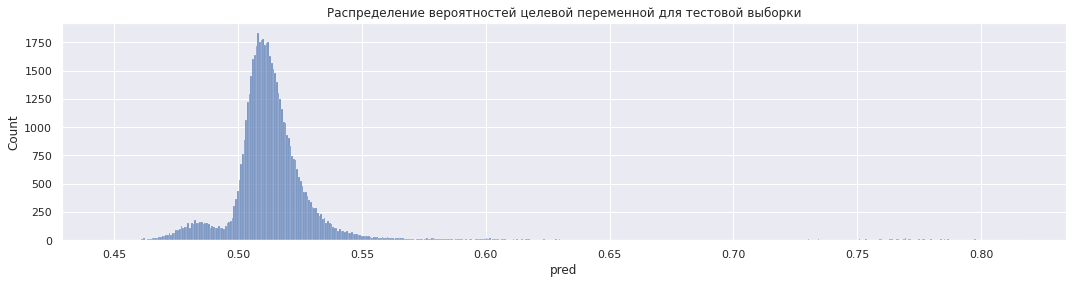

In [60]:
plt.figure(figsize=(18, 4))
plt.title('Распределение вероятностей целевой переменной для тестовой выборки')
sns.histplot(test['pred']);

In [62]:
# Сохранение предсказаний
test.to_csv(Path('/', 'kaggle', 'working', 'submission.csv'))